In [5]:
import numpy as np # linear algebra
import pandas as pd

In [6]:
df = pd.read_csv("synthetic_fraud_dataset.csv")
df.head(3)

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1


In [7]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.columns

Index(['transaction_id', 'user_id', 'transaction_amount', 'transaction_type',
       'timestamp', 'account_balance', 'device_type', 'location',
       'merchant_category', 'ip_address_flag', 'previous_fraudulent_activity',
       'daily_transaction_count', 'avg_transaction_amount_7d',
       'failed_transaction_count_7d', 'card_type', 'card_age',
       'transaction_distance', 'authentication_method', 'risk_score',
       'is_weekend', 'fraud_label'],
      dtype='object')

In [8]:
df1 = df.drop(['transaction_id','user_id'],axis=1)
df1.head(3)

,transaction_amount,transaction_type,timestamp,account_balance,device_type,location,merchant_category,ip_address_flag,previous_fraudulent_activity,daily_transaction_count,avg_transaction_amount_7d,failed_transaction_count_7d,card_type,card_age,transaction_distance,authentication_method,risk_score,is_weekend,fraud_label
0,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1


We perform train test split before doing EDA to prevent data leakage

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Optional: SMOTE for class imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Assuming df1 is already defined with 'fraud_label' as target
X = df1.drop("fraud_label", axis="columns")
y = df1["fraud_label"]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Dictionary of classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Evaluate each classifier using ROC AUC
for name, classifier in classifiers.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict probability for ROC AUC
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)

    print(f"{name} AUC-ROC: {auc_score:.4f}")


Logistic Regression AUC-ROC: 0.8928
Random Forest AUC-ROC: 1.0000
SVM AUC-ROC: 0.9990


c:\Users\Sai babu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost AUC-ROC: 1.0000
[LightGBM] [Info] Number of positive: 27168, number of negative: 27168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8468
[LightGBM] [Info] Number of data points in the train set: 54336, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM AUC-ROC: 1.0000
CatBoost AUC-ROC: 1.0000


AUC-ROC close to 1.0 is ideal, but perfect scores (1.0000) on Random Forest and XGBoost suggest potential overfitting.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = {}

for name, model in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('classifier', model)  
    ])
    
    auc = cross_val_score(pipeline, X, y, cv=cv, scoring=make_scorer(roc_auc_score)).mean()
    auc_scores[name] = auc
    print(f"{name} AUC-ROC: {auc:.4f}")

# Display results
print("\nFinal AUC-ROC Scores:")
for model, auc in auc_scores.items():
    print(f"{model}: {auc:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC-ROC: 0.7638
Random Forest AUC-ROC: 1.0000
SVM AUC-ROC: 0.9771
XGBoost AUC-ROC: 0.9992

Final AUC-ROC Scores:
Logistic Regression: 0.7638
Random Forest: 1.0000
SVM: 0.9771
XGBoost: 0.9992


# Conclusion

Logistic Regression seems to be the most stable model, but its AUC is lower than the others, indicating it may not handle the class imbalance as effectively and the tree models are overfitting. The current analysis does not show  promising results, but further investigation is needed to fully understand the model's behavior, especially with respect to class imbalance and overfitting. We should continue fine-tuning the models and evaluate their performance on unseen data to ensure their generalizability and robustness in real-world applications.



In [10]:
import pandas as pd

# Load the uploaded CSV file
file_path = "synthetic_fraud_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

(None,
   Transaction_ID    User_ID  Transaction_Amount Transaction_Type  \
 0      TXN_33553  USER_1834               39.79              POS   
 1       TXN_9427  USER_7875                1.19    Bank Transfer   
 2        TXN_199  USER_2734               28.96           Online   
 3      TXN_12447  USER_2617              254.32   ATM Withdrawal   
 4      TXN_39489  USER_2014               31.28              POS   
 
              Timestamp  Account_Balance Device_Type  Location  \
 0  2023-08-14 19:30:00         93213.17      Laptop    Sydney   
 1  2023-06-07 04:01:00         75725.25      Mobile  New York   
 2  2023-06-20 15:25:00          1588.96      Tablet    Mumbai   
 3  2023-12-07 00:31:00         76807.20      Tablet  New York   
 4  2023-11-11 23:44:00         92354.66      Mobile    Mumbai   
 
   Merchant_Category  IP_Address_Flag  ...  Daily_Transaction_Count  \
 0            Travel                0  ...                        7   
 1          Clothing                0

In [11]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for class distribution in the target
fraud_distribution = df['Fraud_Label'].value_counts(normalize=True) * 100

# Check data types and unique values in categorical features
categorical_summary = df.select_dtypes(include='object').nunique()

# Show class balance, missing values, and categorical uniqueness
missing_values, fraud_distribution, categorical_summary


(Transaction_ID                  0
 User_ID                         0
 Transaction_Amount              0
 Transaction_Type                0
 Timestamp                       0
 Account_Balance                 0
 Device_Type                     0
 Location                        0
 Merchant_Category               0
 IP_Address_Flag                 0
 Previous_Fraudulent_Activity    0
 Daily_Transaction_Count         0
 Avg_Transaction_Amount_7d       0
 Failed_Transaction_Count_7d     0
 Card_Type                       0
 Card_Age                        0
 Transaction_Distance            0
 Authentication_Method           0
 Risk_Score                      0
 Is_Weekend                      0
 Fraud_Label                     0
 dtype: int64,
 Fraud_Label
 0    67.866
 1    32.134
 Name: proportion, dtype: float64,
 Transaction_ID           50000
 User_ID                   8963
 Transaction_Type             4
 Timestamp                47724
 Device_Type                  3
 Location       

In [12]:
# Drop high-cardinality or non-informative columns
df_cleaned = df.drop(columns=["Transaction_ID", "User_ID"])

# Convert Timestamp to datetime and extract useful features
df_cleaned["Timestamp"] = pd.to_datetime(df_cleaned["Timestamp"])
df_cleaned["Transaction_Hour"] = df_cleaned["Timestamp"].dt.hour
df_cleaned["Transaction_DayOfWeek"] = df_cleaned["Timestamp"].dt.dayofweek
df_cleaned = df_cleaned.drop(columns=["Timestamp"])  # Drop original Timestamp

# Show updated DataFrame structure
df_cleaned.info(), df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_Amount            50000 non-null  float64
 1   Transaction_Type              50000 non-null  object 
 2   Account_Balance               50000 non-null  float64
 3   Device_Type                   50000 non-null  object 
 4   Location                      50000 non-null  object 
 5   Merchant_Category             50000 non-null  object 
 6   IP_Address_Flag               50000 non-null  int64  
 7   Previous_Fraudulent_Activity  50000 non-null  int64  
 8   Daily_Transaction_Count       50000 non-null  int64  
 9   Avg_Transaction_Amount_7d     50000 non-null  float64
 10  Failed_Transaction_Count_7d   50000 non-null  int64  
 11  Card_Type                     50000 non-null  object 
 12  Card_Age                      50000 non-null  int64  
 13  T

(None,
    Transaction_Amount Transaction_Type  Account_Balance Device_Type  Location  \
 0               39.79              POS         93213.17      Laptop    Sydney   
 1                1.19    Bank Transfer         75725.25      Mobile  New York   
 2               28.96           Online          1588.96      Tablet    Mumbai   
 3              254.32   ATM Withdrawal         76807.20      Tablet  New York   
 4               31.28              POS         92354.66      Mobile    Mumbai   
 
   Merchant_Category  IP_Address_Flag  Previous_Fraudulent_Activity  \
 0            Travel                0                             0   
 1          Clothing                0                             0   
 2       Restaurants                0                             0   
 3          Clothing                0                             0   
 4       Electronics                0                             1   
 
    Daily_Transaction_Count  Avg_Transaction_Amount_7d  \
 0           

C:\Users\Sai babu\AppData\Local\Temp\ipykernel_34924\1920560802.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_cleaned, x="Fraud_Label", palette="viridis")


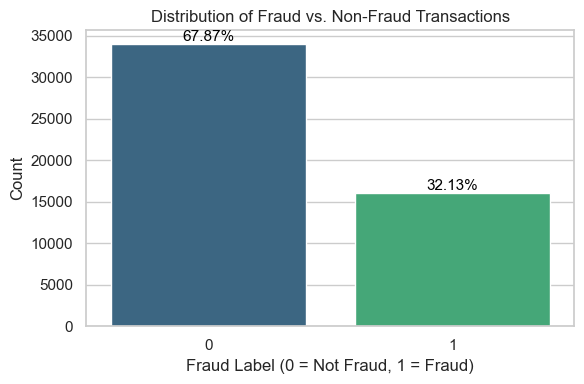

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot the distribution of the Fraud_Label
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_cleaned, x="Fraud_Label", palette="viridis")
plt.title("Distribution of Fraud vs. Non-Fraud Transactions")
plt.xlabel("Fraud Label (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Count")

# Annotate percentages on bars
total = len(df_cleaned)
for p in ax.patches:
    count = p.get_height()
    percent = f'{100 * count / total:.2f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2, count), 
                ha='center', va='bottom', fontsize=11, color='black')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Split into features and target
X = df_cleaned.drop("Fraud_Label", axis=1)
y = df_cleaned["Fraud_Label"]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

# Display summary of preprocessing pipeline
{
    "Numeric Columns": list(num_cols),
    "Categorical Columns": list(cat_cols),
    "Train Shape": X_train.shape,
    "Test Shape": X_test.shape
}


{'Numeric Columns': ['Transaction_Amount',
  'Account_Balance',
  'IP_Address_Flag',
  'Previous_Fraudulent_Activity',
  'Daily_Transaction_Count',
  'Avg_Transaction_Amount_7d',
  'Failed_Transaction_Count_7d',
  'Card_Age',
  'Transaction_Distance',
  'Risk_Score',
  'Is_Weekend'],
 'Categorical Columns': ['Transaction_Type',
  'Device_Type',
  'Location',
  'Merchant_Category',
  'Card_Type',
  'Authentication_Method'],
 'Train Shape': (40000, 19),
 'Test Shape': (10000, 19)}

In [19]:
import joblib  # add this at the top of your file if not already imported

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Re-define the classifiers (again for safety)
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Dictionary to store AUC scores
model_scores = {}

# Train, evaluate, and save each classifier using SMOTE
for name, clf in classifiers.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', clf)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    model_scores[name] = auc

    # Save the model to file
    filename = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(pipeline, filename)
    print(f"Saved: {filename}")

# Display all model AUC scores
model_scores


Saved: logistic_regression_model.pkl
Saved: random_forest_model.pkl
Saved: svm_model.pkl


c:\Users\Sai babu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved: xgboost_model.pkl
[LightGBM] [Info] Number of positive: 27146, number of negative: 27146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8470
[LightGBM] [Info] Number of data points in the train set: 54292, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Saved: lightgbm_model.pkl
Saved: catboost_model.pkl


{'Logistic Regression': 0.8897641731086292,
 'Random Forest': 1.0,
 'SVM': 0.9990496468711743,
 'XGBoost': 0.9999995414238907,
 'LightGBM': 0.9999966982520134,
 'CatBoost': 1.0}

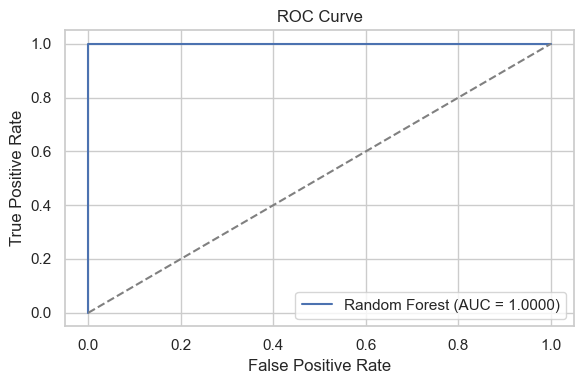

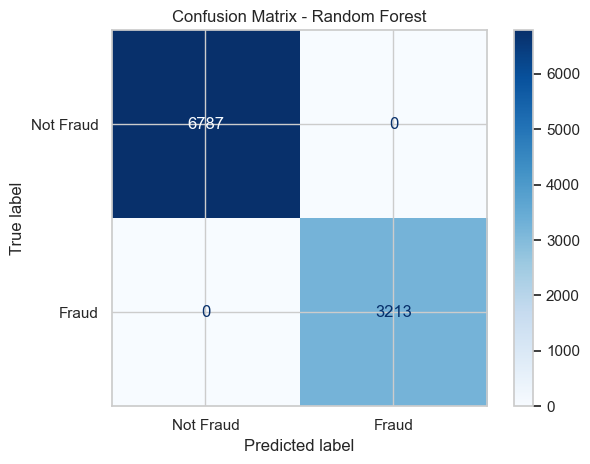

(1.0, 0.0)

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest as the best working model for now
best_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier())
])

# Fit model on training data
best_model.fit(X_train, y_train)

# Save model to file
joblib.dump(best_model, 'random_forest_fraud_model.pkl')

# Predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# Cross-validation on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

cv_scores.mean(), cv_scores.std()


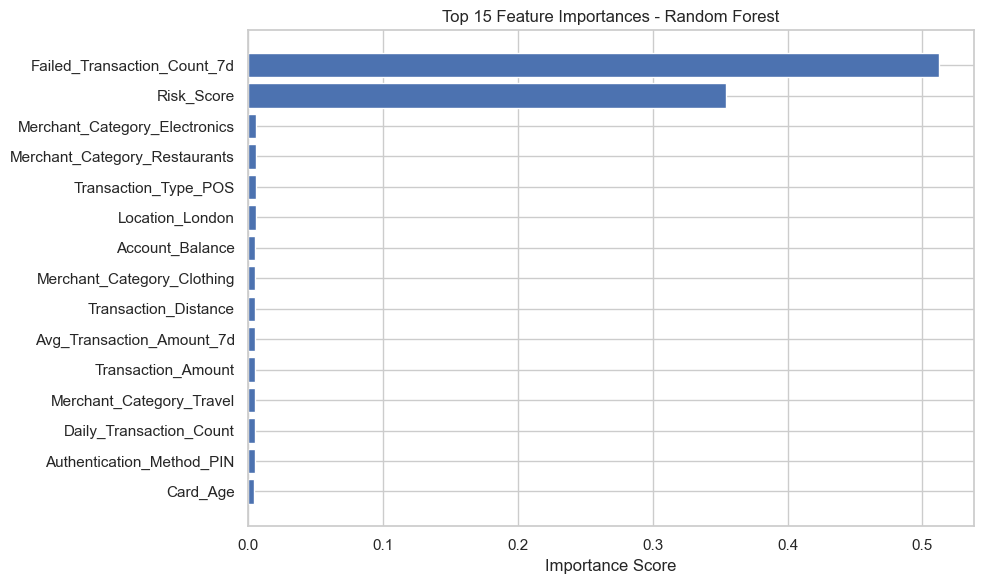

,Feature,Importance
6,Failed_Transaction_Count_7d,0.512630
9,Risk_Score,0.354312
24,Merchant_Category_Electronics,0.006181
26,Merchant_Category_Restaurants,0.005946
14,Transaction_Type_POS,0.005863
18,Location_London,0.005753
1,Account_Balance,0.005407
23,Merchant_Category_Clothing,0.005289
8,Transaction_Distance,0.005259
5,Avg_Transaction_Amount_7d,0.005165


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names from the preprocessor
# This includes both numeric and one-hot encoded categorical names
numeric_features = list(preprocessor.transformers_[0][2])
categorical_features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(preprocessor.transformers_[1][2]))
all_features = numeric_features + list(categorical_features)

# Get the trained Random Forest model from the pipeline
rf_model = best_model.named_steps['classifier']

# Get feature importances and map to feature names
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

feature_importance_df


In [27]:
import ace_tools as tools; tools.display_dataframe_to_user(name="Predictions on Unseen Samples", dataframe=unseen_with_preds)


ModuleNotFoundError: No module named 'ace_tools'

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import joblib

# Step 1: Load the dataset
df = pd.read_csv("synthetic_fraud_dataset.csv")

# Step 2: Feature engineering
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Transaction_Hour"] = df["Timestamp"].dt.hour
df["Transaction_DayOfWeek"] = df["Timestamp"].dt.dayofweek

# Step 3: Drop unnecessary columns
df.drop(columns=["Transaction_ID", "User_ID", "Timestamp"], inplace=True)

# Step 4: Split into features and target
X = df.drop("Fraud_Label", axis=1)
y = df["Fraud_Label"]

# Step 5: Identify column types
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 7: Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Step 8: Final model pipeline
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Step 9: Fit the model
final_model.fit(X_train, y_train)

# Step 10: Save the model
joblib.dump(final_model, "random_forest_fraud_model.pkl")
print("✅ Model saved as 'random_forest_fraud_model.pkl'")

# Step 11: Predict on unseen samples
unseen_samples = X_test.sample(5, random_state=42)
pred_probs = final_model.predict_proba(unseen_samples)

# Step 12: Combine predictions with fraud probability
unseen_with_preds = unseen_samples.copy()
unseen_with_preds["Fraud_Probability"] = pred_probs[:, 1]

# Step 13: Add visual fraud status label
unseen_with_preds["Fraud_Status"] = unseen_with_preds["Fraud_Probability"].apply(
    lambda x: "🟥 Fraud Detected" if x > 0.5 else "🟩 No Fraud Detected"
)

# Step 14: Print result
print("\n📊 Predictions with Fraud Status:\n")
print(unseen_with_preds[["Fraud_Probability", "Fraud_Status"]])


✅ Model saved as 'random_forest_fraud_model.pkl'

📊 Predictions with Fraud Status:

       Fraud_Probability         Fraud_Status
45381               0.02  🟩 No Fraud Detected
28269               0.99     🟥 Fraud Detected
49246               0.98     🟥 Fraud Detected
25357               0.01  🟩 No Fraud Detected
3128                0.06  🟩 No Fraud Detected
